In [1]:
%matplotlib inline

In [2]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set(style="whitegrid")

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 200)

# Email Provider Comparison

Marketing engaged two email providers to provide sample email lists for a marketing test. Each email list had 50,000 email addresses. There was one duplicate email so there were only 99,999 sends.

This analysis seeks to determine which of the two email list providers, Provider A or Provider B, supplied us with the better list.

We will look at:

* sends
* opens (and open rate)
* clicks (and click "through" rate)
* purchases (and the purchase or conversion rate)

We are also interested in our experience with each list compared to the industry benchmark of 14.92% open rate and a 2.3% click rate.

We'll start by loading the relevant data from the sends table: email, send_date, opened, opened_date, clicked:

In [3]:
import sqlite3

In [4]:
data = pd.read_sql_query("SELECT * FROM sends", sqlite3.connect('reporting.db'))

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Data columns (total 6 columns):
email         99999 non-null object
send_date     99999 non-null object
opened        99999 non-null int64
open_date     99999 non-null object
clicked       99999 non-null int64
click_date    99999 non-null object
dtypes: int64(2), object(4)
memory usage: 4.6+ MB


As previously mentioned, there are 99,999 records for this test because there was one email address that was in both lists and we do not send the same email to the same person more than once.

All the variables have the same counts so there are no missing values.

Let's see a sampling of the data:

In [6]:
data.head()

,email,send_date,opened,open_date,clicked,click_date
0,allen.carter3056@gmail.com,2017-08-01,0,,0,
1,christina.ryan1627@gmail.com,2017-08-01,0,,0,
2,jose.woods6517@gmail.com,2017-08-01,0,,0,
3,kayla.miller5652@yahoo.com,2017-08-01,0,,0,
4,paul.rich5663@verizon.net,2017-08-01,0,,0,


We are mostly interested in the opened and clicked counts because they allow us to calculate the open and click rates. However, we will need to pull in information about which list they were on ("campaigns" table) and what they purchased, if anything ("purchases" table). 

Additionally, based on early discussions, it was suggested that the email provider of each person contains some information about them.

Let's start by getting all the information we need from the database. The relevant tables are:

```
CREATE TABLE sends (
  "email" TEXT,
  "send_date" TEXT,
  "opened" INT,
  "open_date" TEXT,
  "clicked" INT,
  "click_date" TEXT
);
```

```
CREATE TABLE purchases(
  "email" TEXT,
  "purchases" INT,
  "unit_price" REAL,
  "total" REAL
);
```

```
CREATE TABLE campaigns(
  "first_name" TEXT,
  "last_name" TEXT,
  "email" TEXT,
  "list_provider" TEXT
);
```

(There are a variety of different ways this could have been done but the easiest is probably to just pull the information all at once from the database):

In [7]:
sql = """
SELECT s.*, c.list_provider, p.purchases, p.unit_price, p.total
FROM sends s
JOIN campaigns c ON s.email = c.email
LEFT JOIN purchases p ON s.email = p.email
"""

In [8]:
data = pd.read_sql_query(sql, sqlite3.connect('reporting.db'))

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 10 columns):
email            100000 non-null object
send_date        100000 non-null object
opened           100000 non-null int64
open_date        100000 non-null object
clicked          100000 non-null int64
click_date       100000 non-null object
list_provider    100000 non-null object
purchases        318 non-null float64
unit_price       318 non-null float64
total            318 non-null float64
dtypes: float64(3), int64(2), object(5)
memory usage: 7.6+ MB


Now we have a bit of a problem. Because we joined campaigns, we picked up our duplicate email address. What should we do about her? (You did make notes about who it was, right?)

```
Jessica,Kelley,jessica.kelley9303@gmail.com
```

Logically, if List A was sent out first (we checked with Engineering), then she only received the email as a member of List A and we can delete her from List B:

In [10]:
data = data.drop(data[(data.email == 'jessica.kelley9303@gmail.com') & (data.list_provider == 'B')].index)

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99999 entries, 0 to 99999
Data columns (total 10 columns):
email            99999 non-null object
send_date        99999 non-null object
opened           99999 non-null int64
open_date        99999 non-null object
clicked          99999 non-null int64
click_date       99999 non-null object
list_provider    99999 non-null object
purchases        318 non-null float64
unit_price       318 non-null float64
total            318 non-null float64
dtypes: float64(3), int64(2), object(5)
memory usage: 8.4+ MB


## Single Variable Analysis

Before we start comparing the different variables against the List Provider, we will look at each variable individually and see if there are any overall problems or patterns. We'll start with sends:

### sends

The total sends is the number of rows of data:

In [12]:
sends = data.send_date.size
sends

99999

There were 99,999 total sends.

### opened

Opens are the number of sends that were opened by their recipient, assuming that they received them.

In [13]:
data.opened.value_counts()

0    83700
1    16299
Name: opened, dtype: int64

The overall open *rate* is the relative frequency of opens:

In [14]:
data.opened.value_counts(normalize=True)

0    0.837008
1    0.162992
Name: opened, dtype: float64

Our overall open rate was 16.3%

### clicked

Clicks are the number of emails that were opened and the recipient clicked something, taking them to our website.

In [15]:
data.clicked.value_counts()

0    97794
1     2205
Name: clicked, dtype: int64

The overall click *rate* is the relative frequency of clicks:

In [16]:
data.clicked.value_counts(normalize=True)

0    0.97795
1    0.02205
Name: clicked, dtype: float64

The overall click rate is 2.2%

### purchases

The purchase variable represents how many items were purchased. This is a discrete numerical variable with bounded domain (10) because we limited the number of items anyone could buy. Typically, we'll see something like an exponential distribution with a large number buying 1 item, about half that number buying 2, etc (technically, a *geometric* distribution).

We can first look just at the raw counts:

In [17]:
data.purchases.value_counts().sort_index()

1.0     101
2.0      50
3.0      42
4.0      40
5.0      19
6.0      10
7.0       7
8.0       4
9.0       8
10.0     37
Name: purchases, dtype: int64

That's a little bit odd. Let's plot the data using a bar chart:

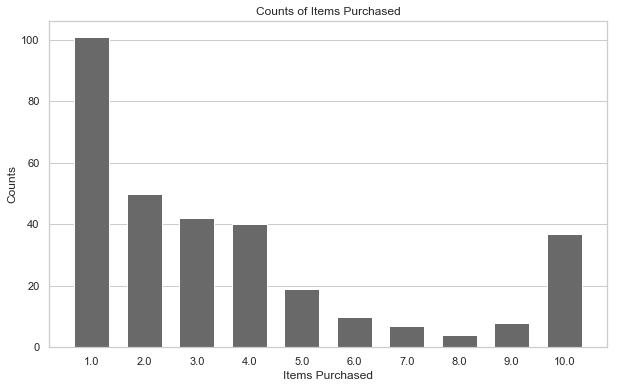

In [18]:
counts = data.purchases.value_counts().sort_index()
x = range( len( counts))
width = 1/1.5

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.bar(x, counts, width, color="dimgray", align="center")
axes.set_xticks(x)
axes.set_xticklabels(counts.axes[0])
axes.set_title( "Counts of Items Purchased")
axes.set_xlabel("Items Purchased")
axes.set_ylabel( "Counts")
axes.xaxis.grid(False)

plt.show()
plt.close()

The overall distribution fits our expectations although it flattens a bit more than expected with 3-4 items. Additionally, there is a strange spike in purchases at 10 items. This is interesting but germane to the current question and so we'll leave it for later. Whenever data departs from a well known pattern it generally indicates that more than one process is present.

### Total

The total purchase in dollars should follow approximately the same pattern as purchases.

In [19]:
data.total.describe()

count    318.000000
mean      31.419340
std       23.278998
min        9.990000
25%        9.990000
50%       26.970000
75%       44.950000
max       79.900000
Name: total, dtype: float64

The minimum is \$9.99 which represents buying 1 item at the per unit price of \$9.99. At the other extreme, the maximum total paid is 10 items at \$7.99 each or \$79.99. (Note that the `describe()` function dropped missing values).

The 1st quartile is still \$9.99 which support our intuition. The mean is \$31.42 and the median is slightly smaller at \$26.97.

Let's plot a histogram of the values:

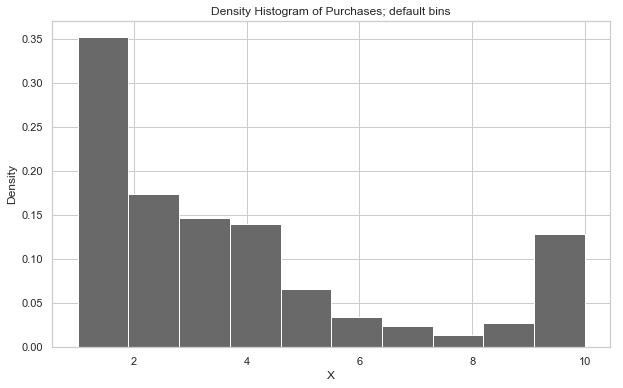

In [20]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)

axes.hist( data.purchases[data.purchases > 0], density=True, color="DimGray")
axes.set_ylabel( "Density")
axes.set_xlabel( "X")
axes.set_title("Density Histogram of Purchases; default bins")

plt.show()
plt.close()

### List Provider

The final variable we need to look at is List Provider. As we have already seen, we expect the count for List A to be 50,000 and the count for List B to be 49,999:

In [21]:
data.list_provider.value_counts()

A    50000
B    49999
Name: list_provider, dtype: int64

## New Variables

There are two new variables we want to create from the data we already have. First, we want to create a true/false *purchased* variable to act just like the opened and clicked variables. Second, we want to create an email provider variable that indicates what kind of email the person has.

### Purchased

In [22]:
data["purchased"] = data["purchases"].apply(lambda x: 1 if x > 0 else 0)

In [23]:
data.purchased.value_counts()

0    99681
1      318
Name: purchased, dtype: int64

gives us the same kind of boolean (Bernoulli trial) variable. We can also get the purchase or conversion rate from it:

In [24]:
data.purchased.value_counts(normalize=True)

0    0.99682
1    0.00318
Name: purchased, dtype: float64

our conversion rate is about 0.3%

### Provider

Now we want to create a provider variable:

In [25]:
data["provider"] = data["email"].apply(lambda x: x[x.index('@')+1:])

What distribution do we expect to see? More gmail addresses than the others.

In [26]:
data.provider.value_counts()

gmail.com      42267
yahoo.com      35390
aol.com         9066
msn.com         5456
comcast.net     4398
verizon.net     3422
Name: provider, dtype: int64

Gmail is the most common but Yahoo is not far away, at least in this data set. There are also some AOL and MSN emails as well as the internet providers, Comcast and Verizon. Let's look at the percentages:

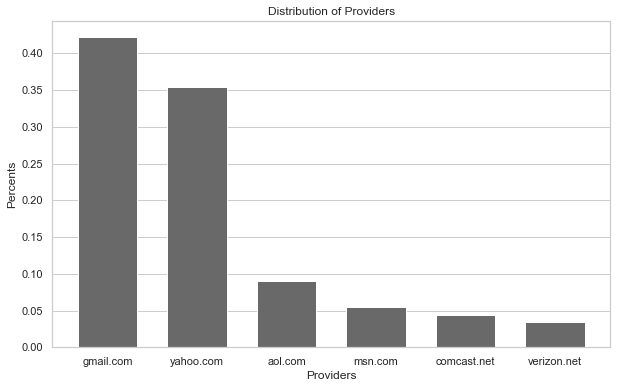

In [27]:
percents = data.provider.value_counts(normalize=True)
x = range( len( percents))
width = 1/1.5

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.bar(x, percents, width, color="dimgray", align="center")
axes.set_xticks(x)
axes.set_xticklabels(percents.axes[0])
axes.set_title( "Distribution of Providers")
axes.set_xlabel("Providers")
axes.set_ylabel( "Percents")
axes.xaxis.grid(False)

plt.show()
plt.close()

The providers are dominated by gmail and yahoo. The other providers account about 20% of the recipients.

## From Overall to List Provider

The previous analysis focused on the overall data but Marketing is interested in comparing the rates between the two List Providers. In the following analysis, we look at the rates by List Provider. We start with opens:

In [28]:
def bootstrap(series, f, resamples=100):
    n = series.size
    results = []
    for _ in range(0, resamples):
        resample = series.sample(n=n, replace=True)
        result = f(resample)
        results.append(result)
    return pd.Series(results)

## Open Rates by List Provider

We look at a crosstab of frequencies to get the open rates per provider:

In [29]:
frequencies = pd.crosstab( data.opened, data.list_provider).apply(lambda r: r/r.sum(), axis=0)
print( frequencies)

list_provider        A         B
opened                          
0              0.82584  0.848177
1              0.17416  0.151823


The open rate was 17.4% for List A and 15.2% for List B, a difference of 2.2 percentage *points* or a *lift* of 14.5%. 

The observed open rate is 17.4% for List A and 15.2% for List B with a difference of 2.2 percentage points. But these are just estimates. All we really observed were sends and opens for particular lists. The observed data (*opens*) is consistent with a variety of actual open *rates*. 

1. How confident are we in possible values of the open rate for each list?
2. What is the probability that the difference between the two lists greater than zero?
3. What is the probability that the open rate is different from the industry standard of 14.92 if we take 14-16% as a Region of Practical Equivalence?

We can answer these questions by calculating bootstrap samples.

(Setting the seed like this is not necessary in general but it is necessary if you're to get the same results I did)

In [30]:
np.random.seed(746475)

In [31]:
inference = {}
inference["opened"] = {}

In [32]:
inference["opened"]["A"] = bootstrap(data[data.list_provider == "A"]["opened"], np.mean)
inference["opened"]["A"].describe()

count    100.000000
mean       0.174006
std        0.001634
min        0.169380
25%        0.172820
50%        0.174050
75%        0.175085
max        0.178840
dtype: float64

The mean should be about the open rate we observed for List A.

In [33]:
inference["opened"]["B"] = bootstrap(data[data.list_provider == "B"]["opened"], np.mean)
inference["opened"]["B"].describe()

count    100.000000
mean       0.151769
std        0.001605
min        0.148663
25%        0.150508
50%        0.151823
75%        0.152908
max        0.157263
dtype: float64

In [34]:
inference["opened"]["difference"] = inference["opened"]["A"] - inference["opened"]["B"]
inference["opened"]["difference"].describe()

count    100.000000
mean       0.022237
std        0.002203
min        0.016857
25%        0.020807
50%        0.022437
75%        0.023842
max        0.027397
dtype: float64

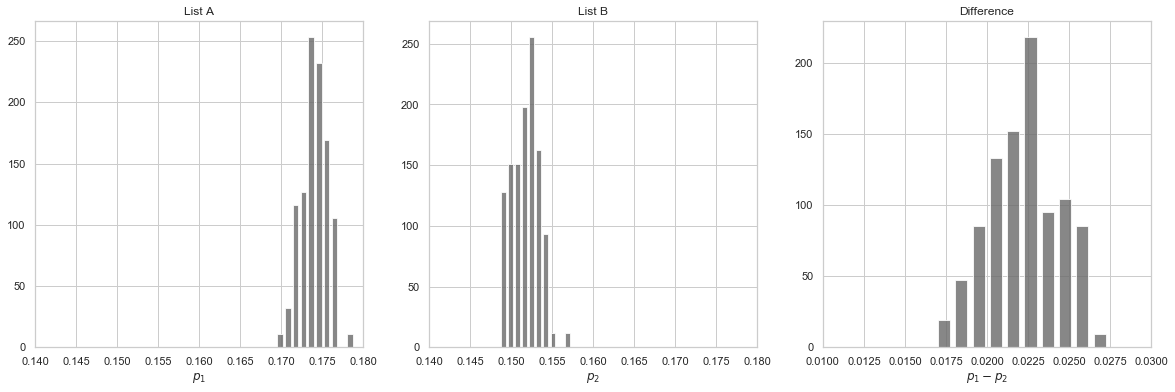

In [35]:
ys, bins = np.histogram(inference["opened"]["A"], bins=10, density=True)
width = 0.7*(bins[ 1] - bins[ 0])
center = (bins[ :-1]+bins[1:])/2

figure = plt.figure(figsize=(20,6))

axes = figure.add_subplot(1, 3, 1)

axes.bar( center, ys, align='center', width=width, color="dimgray", alpha=0.8)
axes.set_xlim([0.14, 0.18])
axes.set_xlabel( r"$p_1$")
axes.set_title( "List A")

ys, bins = np.histogram(inference["opened"]["B"], bins=10, density=True)
width = 0.7*(bins[ 1] - bins[ 0])
center = (bins[ :-1]+bins[1:])/2

axes = figure.add_subplot(1, 3, 2)

axes.bar( center, ys, align='center', width=width, color="dimgray", alpha=0.8)
axes.set_xlim([0.14, 0.18])
axes.set_xlabel( r"$p_2$")
axes.set_title( "List B")

ys, bins = np.histogram(inference["opened"]["difference"], bins=10, density=True)
width = 0.7*(bins[ 1] - bins[ 0])
center = (bins[ :-1]+bins[1:])/2

axes = figure.add_subplot(1, 3, 3)

axes.bar( center, ys, align='center', width=width, color="dimgray", alpha=0.8)
axes.set_xlim([0.01, 0.03])
axes.set_xlabel( r"$p_1 - p_2$")
axes.set_title( "Difference")

plt.show()
plt.close()

We can now answer the questions we posed above.

**1. How confident are we in possible values of the open rate for each list?**

The 95% credible intervals for each open rate are:

In [36]:
print("List A open rate (95% CI)", stats.mstats.mquantiles(inference["opened"]["A"], [0.025, 0.975]))
print("List B open rate (95% CI)", stats.mstats.mquantiles(inference["opened"]["B"], [0.025, 0.975]))

List A open rate (95% CI) [0.1709344 0.1767952]
List B open rate (95% CI) [0.14890298 0.15440679]


Based on the data, there is a 95% probability that the List A open rate is between 17.1% and 17.7%. There is a 95% probability that the List B open rate is between 14.9% and 15.4%.

**2. How what is the probability that the difference between the two lists greater than zero?**

There are a number of ways of answering this question. We could define a ROPE of say -0.5 to 0.5 and ask "what is the probability of the difference being in that range". However, since we have observed that List A's open rate is larger than List B's open rate, it's probably easiest to simply answer the questions, what is the probability that List A's open rate is lower than List B's?

In [37]:
print( "P(difference < 0)", np.mean(inference["opened"]["difference"] < 0))

P(difference < 0) 0.0


What we can say here is, based on the data the probability that List A's open rate is lower than List B's is vanishingly small.

**3. What is the probability that the open rate is different from the industry standard of 14.93 if we take 14-16% as a Region of Practical Equivalence?**

Here we can look at each posterior distribution and see what the probability of this ROPE is:

In [38]:
print("List A P(14% <= open rate <= 16%)", np.mean((0.14 <= inference["opened"]["A"]) & (inference["opened"]["A"] <= 0.16)))
print("List B P(14% <= open rate <= 16%)", np.mean((0.14 <= inference["opened"]["B"]) & (inference["opened"]["B"] <= 0.16)))

List A P(14% <= open rate <= 16%) 0.0
List B P(14% <= open rate <= 16%) 1.0


For List A, it's almost certain that the open rate is greater than the industry standard of 14.93%. However, for List B, we are almost certain that the open rate is at the industry standard.

### Click Rates by List Provider

Above, List A had the higher open rate, but List B may still have a higher click rate:

In [39]:
frequencies = pd.crosstab( data.clicked, data.list_provider).apply(lambda r: r/r.sum(), axis=0)
print( frequencies)

list_provider        A        B
clicked                        
0              0.97528  0.98062
1              0.02472  0.01938


List A has the higher click rate but not by much. We'll have to see if the difference is *meaningful* in a moment.

In [40]:
inference["clicked"] = {}

In [41]:
inference["clicked"]["A"] = bootstrap(data[data.list_provider == "A"]["clicked"], np.mean)
inference["clicked"]["B"] = bootstrap(data[data.list_provider == "B"]["clicked"], np.mean)
inference["clicked"]["difference"] = inference["clicked"]["A"] - inference["clicked"]["B"]

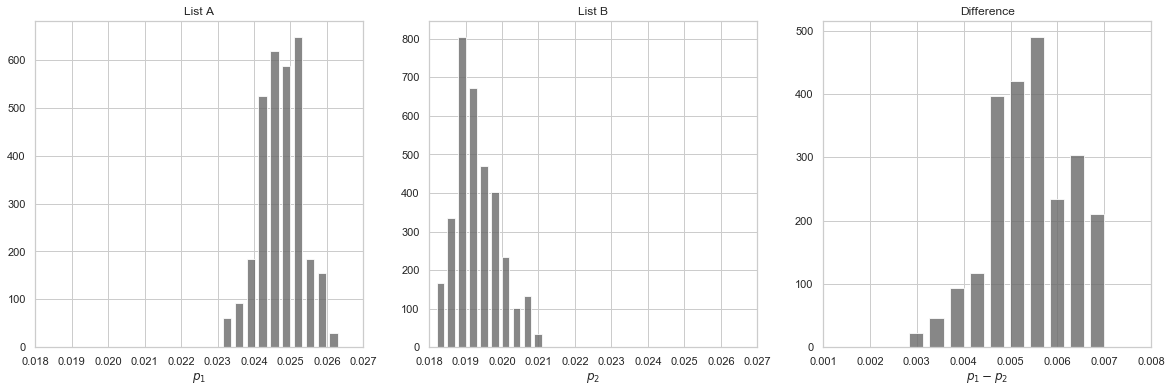

In [42]:
ys, bins = np.histogram(inference["clicked"]["A"], bins=10, density=True)
width = 0.7*(bins[ 1] - bins[ 0])
center = (bins[ :-1]+bins[1:])/2

figure = plt.figure(figsize=(20,6))

axes = figure.add_subplot(1, 3, 1)

axes.bar( center, ys, align='center', width=width, color="dimgray", alpha=0.8)
axes.set_xlim([0.018, 0.027])
axes.set_xlabel( r"$p_1$")
axes.set_title( "List A")

ys, bins = np.histogram(inference["clicked"]["B"], bins=10, density=True)
width = 0.7*(bins[ 1] - bins[ 0])
center = (bins[ :-1]+bins[1:])/2

axes = figure.add_subplot(1, 3, 2)

axes.bar( center, ys, align='center', width=width, color="dimgray", alpha=0.8)
axes.set_xlim([0.018, 0.027])
axes.set_xlabel( r"$p_2$")
axes.set_title( "List B")

ys, bins = np.histogram(inference["clicked"]["difference"], bins=10, density=True)
width = 0.7*(bins[ 1] - bins[ 0])
center = (bins[ :-1]+bins[1:])/2

axes = figure.add_subplot(1, 3, 3)

axes.bar( center, ys, align='center', width=width, color="dimgray", alpha=0.8)
axes.set_xlim([0.001, 0.008])
axes.set_xlabel( r"$p_1 - p_2$")
axes.set_title( "Difference")

plt.show()
plt.close()

We have the same questions for the click rate that we had for the open rate:

**1. How confident are we in possible values of the click rate for each list?**

In [43]:
print("List A click rate (95% CI)", stats.mstats.mquantiles(inference["clicked"]["A"], [0.025, 0.975]))
print("List B click rate (95% CI)", stats.mstats.mquantiles(inference["clicked"]["B"], [0.025, 0.975]))

List A click rate (95% CI) [0.0234553 0.0259095]
List B click rate (95% CI) [0.01827277 0.02072801]


Given the data, there is a 95% probability that the List A click rate is between 2.3% and 2.6% whereas there is 95% probability that the List B click rate is between 1.8% and 2.1%.

**2. How what is the probability that the difference between the two lists greater than zero?**


In [44]:
print( "P(difference < 0)", np.mean(inference["clicked"]["difference"] < 0))

P(difference < 0) 0.0


It is very unlikely that the click rate of List A is less than List B's.


**3. What is the probability that the open rate is different from the industry standard of 2.3% if we take 2-2.5% as a Region of Practical Equivalence?**

In [45]:
print("List A P(2% <= click rate <= 2.5%)", np.mean((0.02 <= inference["clicked"]["A"]) & (inference["clicked"]["A"] <= 0.025)))
print("List B P(2% <= click rate <= 2.5%)", np.mean((0.02 <= inference["clicked"]["B"]) & (inference["clicked"]["B"] <= 0.025)))

List A P(2% <= click rate <= 2.5%) 0.66
List B P(2% <= click rate <= 2.5%) 0.14


There is a 66% probability that the List A click rate is at the industry standard whereas there is only a 14% probability that List B is at the industry standard. This makes sense. The observed click rate for List A was 2.3% whereas the observed click rate for List B was 1.9%. Perhaps a better question is, what is the probability that List A's click rate is above the industry average and what is the probability that List B's rate is below the industry average.

Since we considered 2-2.5% to "equivalent" we can ask, what's the probability that List A's click rate is above this ROPE?

In [46]:
print("List A P(click rate > 2.5)", np.mean(0.025 < inference["clicked"]["A"]))

List A P(click rate > 2.5) 0.34


Given the data, there is a 34% probability that List A's click rate is above the industry average.

We can do the same thing for List B but *below* the ROPE:

In [47]:
print("List B P(click rate < 2.0)", np.mean(0.02 > inference["clicked"]["B"]))

List B P(click rate < 2.0) 0.86


Given the data, there is an 86% probability that List B's click rate is below the industry average.

### Purchase Rates by List Provider

Finally, we'll look at the purchase rates by List provider:

In [48]:
frequencies = pd.crosstab( data.purchased, data.list_provider).apply(lambda r: r/r.sum(), axis=0)
print( frequencies)

list_provider       A        B
purchased                     
0              0.9965  0.99714
1              0.0035  0.00286


List A has the higher purchase rate as well, 0.35% versus 0.29%. Overall, it looks like List A may be the better of the two providers. But what if the people on List B bought twice as many items?

### Items per Send

Let's look at the distribution of purchases (items purchased) per List and see if this idea has any support or if we could just work with purchases as a boolean variable (purchased).

Below we have a crosstab of purchases and the two lists:

In [49]:
counts = pd.crosstab(data.purchases, data.list_provider)#.apply(lambda r: r/r.sum(), axis=0)
print(counts)

list_provider   A   B
purchases            
1.0            55  46
2.0            32  18
3.0            18  24
4.0            24  16
5.0            10   9
6.0             8   2
7.0             2   5
8.0             2   2
9.0             6   2
10.0           18  19


They're fairly similar except for the 2 item purchases where the total for List A is nearly twice that of List B. But does List B "catch up" with the 3 item purchases? We really want to see average items per purchase by list provider:

In [50]:
grouped = data.groupby( "list_provider")
grouped_y = grouped["purchases"].describe()
print(grouped_y)

               count      mean       std  min  25%  50%  75%   max
list_provider                                                     
A              175.0  3.605714  2.939812  1.0  1.0  3.0  5.0  10.0
B              143.0  3.734266  3.058010  1.0  1.0  3.0  5.0  10.0


It would appear at first blush that we need to do some kind of statistical test but in this case, we can just use logic. Because the lists are the same size (save Jessica), we don't need to do any normalization and can work directly with the counts. For every 50,000 emails, we can expect 175 or 143 purchases and those purchases will have 3.6 or 3.73 items on average (respectively):

In [51]:
print("List A items purchased per send: ", (175*3.6)/50000)
print("List B items purchased per send: ", (143*3.73)/49999)

List A items purchased per send:  0.0126
List B items purchased per send:  0.010668013360267205


In [52]:
data[["list_provider", "total"]].groupby('list_provider').sum()

,total
list_provider,
A,5415.69
B,4575.66


In [53]:
inference["purchased"] = {}

In [54]:
inference["purchased"]["A"] = bootstrap(data[data.list_provider == "A"]["purchased"], np.mean)
inference["purchased"]["B"] = bootstrap(data[data.list_provider == "B"]["purchased"], np.mean)
inference["purchased"]["difference"] = inference["purchased"]["A"] - inference["purchased"]["B"]

In [55]:
inference["purchased"]["A"].describe()

count    100.000000
mean       0.003461
std        0.000260
min        0.002840
25%        0.003300
50%        0.003450
75%        0.003645
max        0.003980
dtype: float64

In [56]:
inference["purchased"]["B"].describe()

count    100.000000
mean       0.002841
std        0.000241
min        0.002340
25%        0.002660
50%        0.002830
75%        0.003000
max        0.003420
dtype: float64

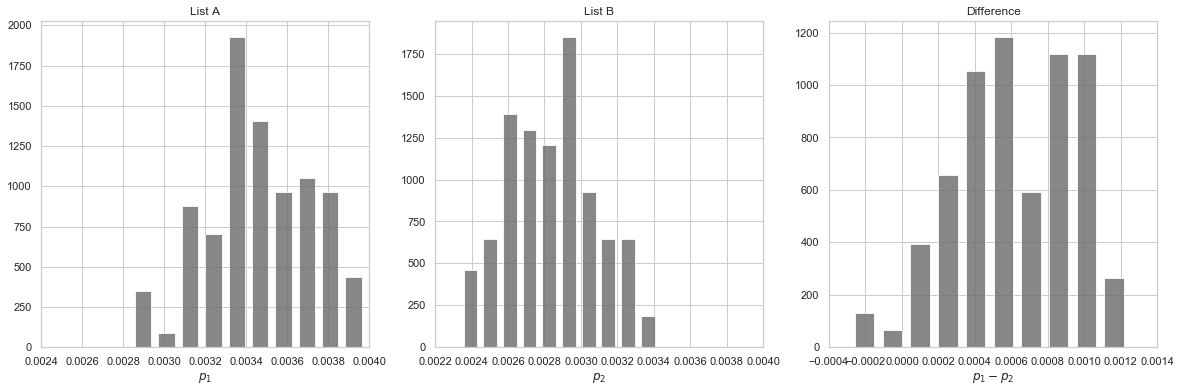

In [57]:
ys, bins = np.histogram(inference["purchased"]["A"], bins=10, density=True)
width = 0.7*(bins[ 1] - bins[ 0])
center = (bins[ :-1]+bins[1:])/2

figure = plt.figure(figsize=(20,6))

axes = figure.add_subplot(1, 3, 1)

axes.bar( center, ys, align='center', width=width, color="dimgray", alpha=0.8)
axes.set_xlim([0.0024, 0.004])
axes.set_xlabel( r"$p_1$")
axes.set_title( "List A")

ys, bins = np.histogram(inference["purchased"]["B"], bins=10, density=True)
width = 0.7*(bins[ 1] - bins[ 0])
center = (bins[ :-1]+bins[1:])/2

axes = figure.add_subplot(1, 3, 2)

axes.bar( center, ys, align='center', width=width, color="dimgray", alpha=0.8)
axes.set_xlim([0.0022, 0.004])
axes.set_xlabel( r"$p_2$")
axes.set_title( "List B")

ys, bins = np.histogram(inference["purchased"]["difference"], bins=10, density=True)
width = 0.7*(bins[ 1] - bins[ 0])
center = (bins[ :-1]+bins[1:])/2

axes = figure.add_subplot(1, 3, 3)

axes.bar( center, ys, align='center', width=width, color="dimgray", alpha=0.8)
axes.set_xlim([-0.0004, 0.0014])
axes.set_xlabel( r"$p_1 - p_2$")
axes.set_title( "Difference")

plt.show()
plt.close()

The first two of our three questions is the same for this data as well.


**1. How confident are we in possible values of the purchase rate for each list?**

In [58]:
print("List A purchase rate (95% CI)", stats.mstats.mquantiles(inference["purchased"]["A"], [0.025, 0.975]))
print("List B purchase rate (95% CI)", stats.mstats.mquantiles(inference["purchased"]["B"], [0.025, 0.975]))

List A purchase rate (95% CI) [0.0029181 0.0039419]
List B purchase rate (95% CI) [0.00237815 0.00328577]


**2. How what is the probability that the difference between the two lists greater than zero?**


In [59]:
print( "P(difference < 0)", np.mean(inference["purchased"]["difference"] < 0))

P(difference < 0) 0.03


Based on the data, there is a 97% probability that List A's purchase rate is greater than List B's.

## Further Analysis

At this point we have answered the questions that Marketing asked us to answer. We have a sense of which list provider is likely to do better in the future. Of course, this comes with caveats. They have to send us the same kind of list each time, this can't have been their best performers. The economy in general has to stay steady although if there were a downturn, we'd expect the same hit to both lists.

There are some unanswered questions, though, that might be important in the longer run.

1. What caused the "blip" in purchases at the 10 item level?
2. Do purchase rates differ by (email) provider?
3. What are the confidence bounds for revenue per send?

Additionally, given a industry standard of 14.93% and 2.3% for the open and click rates respectively, we could have used those as priors for our statistical analysis. We might repeat our basic statistical analysis using this prior and MCMC.|

# Report

Marketing recently conducted a test email campaign of two list providers. They, along with engineering, supplied list, send, and purchase information for this test and asked us to evaluate the experiment. We were tasked with answering two basic questions:

1. Did the open and click rates of the two lists differ from industry experience (14.93% and 2.3% respectively)?
2. Based on the purchase rates of the two lists, which provider was better?

Looking at the data, we observed the following rates:

|          | open  | click | purchase |
|----------|-------|-------|----------|
| industry | 14.93 | 2.3   | -        |
| List A   | 17.4  | 2.5   | 0.0035   |
| List B   | 15.2  | 1.9   | 0.0029   |
| A - B    |  2.2  | 0.6   | 0.0006   |

For all three rates, List A performed better than List B. Statistical analysis showed List A was almost certainly better than List B for open and click rates and that there was a 97% probability it was better on purchase rate. Comparing List A to industry standards, it was nearly certain that List A has a higher open rate than industry standards but there was a 66% probability that the click rate was at industry standards (34% probability that it is above).

The confidence intervals for the List A open rate was [0.171, 0.177], the click rate was [0.023, 0.026], and the purchase rate was [0.0029, 0.0039]. These metrics should be monitored if we move forward with provider A.

During the course of the analysis, we uncovered additional questions Marketing might want answered. First, there was a large spike in purchases in at the 10 item limit. Second, we did not investigate the effect that email provider might have had on the performance of the respective lists.